In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
import math
from fbprophet import Prophet
import datetime

In [2]:
#os.chdir('/Users/clairesun/desktop/Sales_Forecast')
df_sales = pd.read_csv('sales_train_v2.csv')

# Data Cleansing. Group items to:
1. Old Items (launched before 2015-01-01) 
2. New Items 1 (launched after 2015-01-01 but before 2015-08-01)
3. New Item 2 (launched after 2015-08-01)

In [3]:
df_sales['date'] = pd.to_datetime(df_sales['date'],dayfirst=True)

In [5]:
#Data Cleansing,fill-in negative prices with mean
mean = int(df_sales.loc[df_sales['item_id']==2973, 'item_price'].mean())
df_sales["item_price"] = df_sales["item_price"].mask(df_sales["item_price"] <0, mean)

In [11]:
# For each row, add 'date-y' column as the launch date of that item
df_sales_2= df_sales.groupby('item_id')['date'].min()
df_sales = df_sales.merge(df_sales_2, right_index = True, left_on = 'item_id', how='left')

In [15]:
Group_Old_item=df_sales.loc[(df_sales['date_y']<'2015-01-01')]
Group_Old_item=Group_Old_item.loc[Group_Old_item.item_price<40000]

Group_New_Item_1=df_sales.loc[(df_sales['date_y']>'2014-12-31')&(df_sales['date_y']<'2015-08-01')]
Group_New_Item_1=Group_New_Item_1.loc[Group_New_Item_1.item_price<40000]

Group_New_Item_2=df_sales.loc[(df_sales['date_y']>'2015-07-31')]
Group_New_Item_2=Group_New_Item_2.loc[Group_New_Item_2.item_price<40000]


# Old Items - Predicted by month
Prophet Model: a.drop the greatest sales row; b.cap = mean of y.; c.daily_seasonality=False & yearly_seasonality=1

In [37]:
# Tried 17717 & 20949 $ 2808, results are acceptable
df_sales_fbprophet= Group_Old_item.loc[(Group_Old_item['item_id']==20949)]

df_sales_fbprophet['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet = df_sales_fbprophet.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet.sort_values(by=['ds'])

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


ds  date_block_num        y
0  2013-04-30               3    255.0
1  2013-05-31               4   3727.0
2  2013-06-30               5   8424.0
3  2013-07-31               6   7269.0
4  2013-08-31               7   7296.0
5  2013-09-30               8   7945.0
6  2013-10-31               9   7738.0
7  2013-11-30              10   8537.0
8  2013-12-31              11  12557.0
9  2014-01-31              12   7329.0
10 2014-02-28              13   6547.0
11 2014-03-31              14   7717.0
12 2014-04-30              15   5875.0
13 2014-05-31              16   5822.0
14 2014-06-30              17   6712.0
15 2014-07-31              18   5976.0
16 2014-08-31              19   6286.0
17 2014-09-30              20   6571.0
18 2014-10-31              21   6547.0
19 2014-11-30              22   7721.0
20 2014-12-31              23  12185.0
21 2015-01-31              24   7869.0
22 2015-02-28              25   3109.0
23 2015-03-31              26   1924.0
24 2015-04-30              27   4097.0
25 2015-05-31              28   3768.0
26 2015-06-30              29   3473.0
27 2015-07-31              30   3347.0
28 2015-08-31              31   3551.0
29 2015-09-30              32   3390.0
30 2015-10-31              33   4078.0

In [38]:
df_sales_fbprophet=df_sales_fbprophet.drop(df_sales_fbprophet['y'].idxmax()) 

In [39]:
df_sales_fbprophet=df_sales_fbprophet.loc[(df_sales_fbprophet['date_block_num']<33)] #drop last month's sales

df_sales_fbprophet_train=df_sales_fbprophet
df_sales_fbprophet_train['floor']=0
df_sales_fbprophet_train['cap']=df_sales_fbprophet_train['y'].mean()

m = Prophet(daily_seasonality=False,yearly_seasonality=1,growth='logistic',seasonality_mode='multiplicative')

m.fit(df_sales_fbprophet_train)


future = m.make_future_dataframe(periods=5, freq='M')
future['floor']=0
future['cap']=df_sales_fbprophet_train['y'].mean()

future.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.


ds  floor          cap
29 2015-10-31      0  5896.793103
30 2015-11-30      0  5896.793103
31 2015-12-31      0  5896.793103
32 2016-01-31      0  5896.793103
33 2016-02-29      0  5896.793103

In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds         yhat   yhat_lower   yhat_upper
29 2015-10-31  3927.309570  1423.956120  6450.712267
30 2015-11-30  3455.687551   955.224267  5748.441486
31 2015-12-31  2797.974126   217.241164  5196.911480
32 2016-01-31  2107.101679  -235.771011  4598.735025
33 2016-02-29  1540.458003  -721.319483  3909.154939

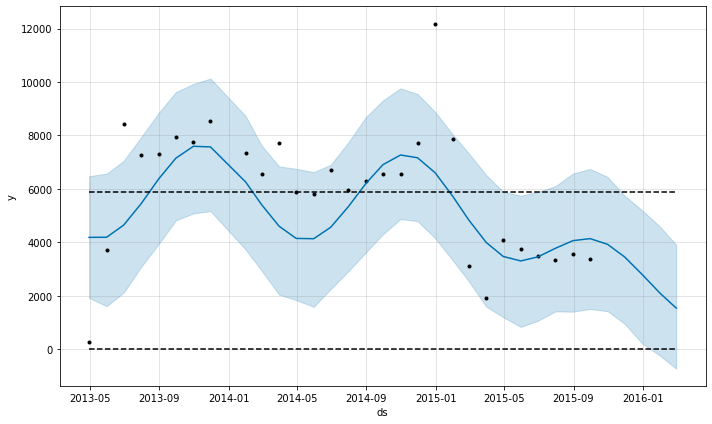

In [41]:
fig1 = m.plot(forecast)

# New Item - 1st Group (launched in 2015 but before 2015-08-01) - Predicted by month
- Prophet Model: a.drop the greatest sales row; b.cap = max of y. ; c.daily_seasonality=True, yearly_seasonality=False; d.floor value?

In [27]:
# Tried 10210
df_sales_fbprophet_n1= Group_New_Item_1[(Group_New_Item_1['item_id']==10210)]

df_sales_fbprophet_n1['date_month'] = datetime.datetime(2013, 1, 31).date() + df_sales_fbprophet_n1['date_block_num'].apply(pd.offsets.MonthEnd) 
df_sales_fbprophet_n1 = df_sales_fbprophet_n1.groupby(['date_month','date_block_num'])['item_cnt_day'].sum().reset_index(name='item_cnt_month')

df_sales_fbprophet_n1 = df_sales_fbprophet_n1.rename(columns={"date_month": "ds", "item_cnt_month": "y"})

df_sales_fbprophet_n1.sort_values(by=['ds'])

/Users/clairesun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


ds  date_block_num       y
0 2015-05-31              28  3275.0
1 2015-06-30              29   764.0
2 2015-07-31              30   332.0
3 2015-08-31              31   242.0
4 2015-09-30              32   122.0
5 2015-10-31              33   141.0

In [28]:
df_sales_fbprophet_n1=df_sales_fbprophet_n1.loc[(df_sales_fbprophet_n1['date_block_num']<33)]
df_sales_fbprophet_n1=df_sales_fbprophet_n1.drop(df_sales_fbprophet_n1['y'].idxmax())

In [29]:
df_sales_fbprophet_train=df_sales_fbprophet_n1
df_sales_fbprophet_train['floor']=0
df_sales_fbprophet_train['cap']=df_sales_fbprophet_train['y'].max()

m = Prophet(n_changepoints=10,daily_seasonality=True,yearly_seasonality=False,growth='logistic',seasonality_mode='multiplicative')

m.fit(df_sales_fbprophet_train)

days_to_predict = pd.to_datetime('2015-12-31') - df_sales_fbprophet_n1['ds'].max()
months_to_predict = round(days_to_predict.days/31)

future = m.make_future_dataframe(periods=months_to_predict, freq='M')
future['floor']=df_sales_fbprophet_train['y'].min()/12
future['cap']=df_sales_fbprophet_train['y'].max()

future.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 2.


ds      floor    cap
2 2015-08-31  10.166667  764.0
3 2015-09-30  10.166667  764.0
4 2015-10-31  10.166667  764.0
5 2015-11-30  10.166667  764.0
6 2015-12-31  10.166667  764.0

In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

ds        yhat  yhat_lower  yhat_upper
2 2015-08-31  297.015199  252.212057  345.183451
3 2015-09-30  201.430513  152.725616  254.225751
4 2015-10-31  150.552506  101.170458  200.052124
5 2015-11-30  125.502094   76.526543  176.815645
6 2015-12-31  112.367143   61.847492  164.401073

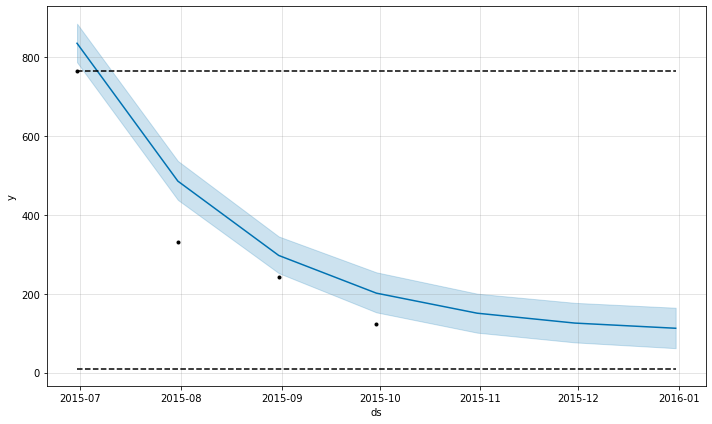

In [31]:
fig1 = m.plot(forecast)

# New items - lauched after 2015-08-01 - Predicted by day
- Prophet model: a. cap = max of y; b. daily_seasonality=True, yearly_seasonality=False; c.floor = 1

In [16]:
df_sales_fbprophet_n2 = Group_New_Item_2.loc[(Group_New_Item_2['item_id']==3351)&(Group_New_Item_2['date_block_num']<34)]
                                
df_sales_fbprophet_n2 = df_sales_fbprophet_n2.groupby(['date_x'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet_n2

date_x  item_cnt_day_total
0  2015-09-22               926.0
1  2015-09-23               188.0
2  2015-09-24               135.0
3  2015-09-25                90.0
4  2015-09-26                88.0
5  2015-09-27                50.0
6  2015-09-28                42.0
7  2015-09-29                27.0
8  2015-09-30                23.0
9  2015-10-01                32.0
10 2015-10-02                30.0
11 2015-10-03                53.0
12 2015-10-04                43.0
13 2015-10-05                15.0
14 2015-10-06                14.0
15 2015-10-07                11.0
16 2015-10-08                13.0
17 2015-10-09                15.0
18 2015-10-10                23.0
19 2015-10-11                20.0
20 2015-10-12                 9.0
21 2015-10-13                 3.0
22 2015-10-14                 8.0
23 2015-10-15                10.0
24 2015-10-16                17.0
25 2015-10-17                13.0
26 2015-10-18                10.0
27 2015-10-19                 3.0
28 2015-10-20                10.0
29 2015-10-21                 8.0
30 2015-10-22                 4.0
31 2015-10-23                 8.0
32 2015-10-24                18.0
33 2015-10-25                 9.0
34 2015-10-26                 8.0
35 2015-10-27                 5.0
36 2015-10-28                 8.0
37 2015-10-29                 7.0
38 2015-10-30                12.0
39 2015-10-31                13.0

In [17]:
df_sales_fbprophet_n2=df_sales_fbprophet_n2.drop(df_sales_fbprophet_n2['item_cnt_day_total'].idxmax())

In [19]:
df_sales_fbprophet_n2 = df_sales_fbprophet_n2.rename(columns={"date_x": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet_n2['floor']=df_sales_fbprophet_n2['y'].min()
df_sales_fbprophet_n2['cap']=df_sales_fbprophet_n2['y'].max()
df_sales_fbprophet_n2

ds      y  floor    cap
1  2015-09-23  188.0    3.0  188.0
2  2015-09-24  135.0    3.0  188.0
3  2015-09-25   90.0    3.0  188.0
4  2015-09-26   88.0    3.0  188.0
5  2015-09-27   50.0    3.0  188.0
6  2015-09-28   42.0    3.0  188.0
7  2015-09-29   27.0    3.0  188.0
8  2015-09-30   23.0    3.0  188.0
9  2015-10-01   32.0    3.0  188.0
10 2015-10-02   30.0    3.0  188.0
11 2015-10-03   53.0    3.0  188.0
12 2015-10-04   43.0    3.0  188.0
13 2015-10-05   15.0    3.0  188.0
14 2015-10-06   14.0    3.0  188.0
15 2015-10-07   11.0    3.0  188.0
16 2015-10-08   13.0    3.0  188.0
17 2015-10-09   15.0    3.0  188.0
18 2015-10-10   23.0    3.0  188.0
19 2015-10-11   20.0    3.0  188.0
20 2015-10-12    9.0    3.0  188.0
21 2015-10-13    3.0    3.0  188.0
22 2015-10-14    8.0    3.0  188.0
23 2015-10-15   10.0    3.0  188.0
24 2015-10-16   17.0    3.0  188.0
25 2015-10-17   13.0    3.0  188.0
26 2015-10-18   10.0    3.0  188.0
27 2015-10-19    3.0    3.0  188.0
28 2015-10-20   10.0    3.0  188.0
29 2015-10-21    8.0    3.0  188.0
30 2015-10-22    4.0    3.0  188.0
31 2015-10-23    8.0    3.0  188.0
32 2015-10-24   18.0    3.0  188.0
33 2015-10-25    9.0    3.0  188.0
34 2015-10-26    8.0    3.0  188.0
35 2015-10-27    5.0    3.0  188.0
36 2015-10-28    8.0    3.0  188.0
37 2015-10-29    7.0    3.0  188.0
38 2015-10-30   12.0    3.0  188.0
39 2015-10-31   13.0    3.0  188.0

In [20]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, 
            seasonality_mode='multiplicative', growth='logistic')
m.fit(df_sales_fbprophet_n2)

In [21]:
days_to_predict = pd.to_datetime('2015-12-31') - df_sales_fbprophet_n2['ds'].max()
days_to_predict.days


61

In [22]:
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=1
future['cap']=df_sales_fbprophet_n2['y'].max()

future.tail(100)

ds  floor    cap
0  2015-09-23      1  188.0
1  2015-09-24      1  188.0
2  2015-09-25      1  188.0
3  2015-09-26      1  188.0
4  2015-09-27      1  188.0
5  2015-09-28      1  188.0
6  2015-09-29      1  188.0
7  2015-09-30      1  188.0
8  2015-10-01      1  188.0
9  2015-10-02      1  188.0
10 2015-10-03      1  188.0
11 2015-10-04      1  188.0
12 2015-10-05      1  188.0
13 2015-10-06      1  188.0
14 2015-10-07      1  188.0
15 2015-10-08      1  188.0
16 2015-10-09      1  188.0
17 2015-10-10      1  188.0
18 2015-10-11      1  188.0
19 2015-10-12      1  188.0
20 2015-10-13      1  188.0
21 2015-10-14      1  188.0
22 2015-10-15      1  188.0
23 2015-10-16      1  188.0
24 2015-10-17      1  188.0
25 2015-10-18      1  188.0
26 2015-10-19      1  188.0
27 2015-10-20      1  188.0
28 2015-10-21      1  188.0
29 2015-10-22      1  188.0
..        ...    ...    ...
70 2015-12-02      1  188.0
71 2015-12-03      1  188.0
72 2015-12-04      1  188.0
73 2015-12-05      1  188.0
74 2015-12-06      1  188.0
75 2015-12-07      1  188.0
76 2015-12-08      1  188.0
77 2015-12-09      1  188.0
78 2015-12-10      1  188.0
79 2015-12-11      1  188.0
80 2015-12-12      1  188.0
81 2015-12-13      1  188.0
82 2015-12-14      1  188.0
83 2015-12-15      1  188.0
84 2015-12-16      1  188.0
85 2015-12-17      1  188.0
86 2015-12-18      1  188.0
87 2015-12-19      1  188.0
88 2015-12-20      1  188.0
89 2015-12-21      1  188.0
90 2015-12-22      1  188.0
91 2015-12-23      1  188.0
92 2015-12-24      1  188.0
93 2015-12-25      1  188.0
94 2015-12-26      1  188.0
95 2015-12-27      1  188.0
96 2015-12-28      1  188.0
97 2015-12-29      1  188.0
98 2015-12-30      1  188.0
99 2015-12-31      1  188.0

[100 rows x 3 columns]

In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
95 2015-12-27   9.024350   -3.093106   20.687195
96 2015-12-28   7.788569   -4.273823   19.693304
97 2015-12-29   5.971183   -6.389696   18.687614
98 2015-12-30  14.183435    2.837051   27.107194
99 2015-12-31  12.472092    0.053463   24.040177

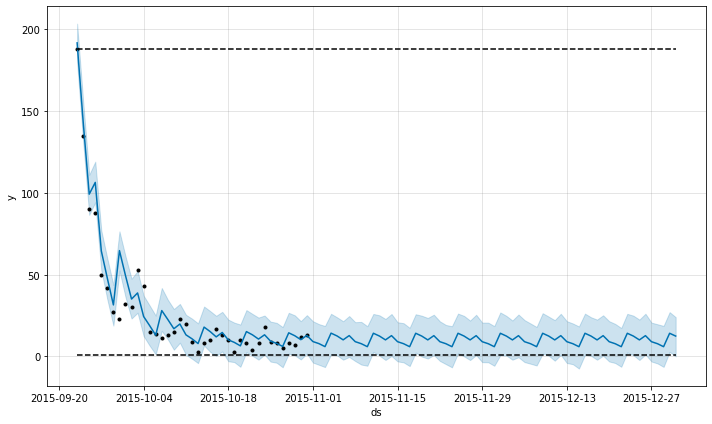

In [24]:
fig1=m.plot(forecast)

In [25]:
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-12-30'))]['yhat']

39     9.107810
40     7.848335
41     6.009201
42    14.258362
43    12.526760
44    10.160117
45    12.764766
46     9.046943
47     7.804747
48     5.981474
49    14.203717
50    12.486891
51    10.133266
52    12.736760
53     9.030465
54     7.792948
55     5.973968
56    14.188924
57    12.476097
58    10.125997
59    12.729178
60     9.026004
61     7.789753
62     5.971936
63    14.184919
64    12.473175
65    10.124030
66    12.727125
67     9.024796
68     7.788888
69     5.971386
70    14.183835
71    12.472385
72    10.123497
73    12.726570
74     9.024469
75     7.788654
76     5.971237
77    14.183542
78    12.472170
79    10.123353
80    12.726419
81     9.024381
82     7.788591
83     5.971197
84    14.183462
85    12.472112
86    10.123314
87    12.726379
88     9.024357
89     7.788574
90     5.971186
91    14.183441
92    12.472097
93    10.123303
94    12.726368
95     9.024350
96     7.788569
97     5.971183
98    14.183435
Name: yhat, dtype: float64

In [26]:
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'].sum()

306.4973522932414